In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

## TRYING OUT DIFFERENT NEURAL NETWORK ARCHITECTURE ON MY DATA 

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, BatchNormalization, LSTM, GRU, Embedding,Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping 

In [3]:
df = pd.read_csv('model_data/aggregateddata.csv',index_col=0)

In [4]:
df['total_individuals_fully_vaccinated']= df['total_individuals_fully_vaccinated'].replace(np.nan,0)

In [5]:
df.head()

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_doses_in_fully_vaccinated_individuals,total_individuals_fully_vaccinated,Daily_Covid_Num,Cum_Covid_Numbers
0,2020-12-24,277,176,967,297,188,NaN,0.0,844,58584
1,2020-12-30,323,204,1230,342,212,NaN,0.0,856,63599
2,2020-12-31,337,210,1270,354,219,NaN,0.0,853,64452
3,2021-01-01,336,221,1269,355,232,NaN,0.0,956,65408
4,2021-01-02,322,220,1287,344,230,NaN,0.0,938,66346


In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
df['report_date'] = pd.to_datetime(df['report_date'])

In [8]:
df = df.drop(['total_doses_in_fully_vaccinated_individuals','Cum_Covid_Numbers'],axis=1)

In [9]:
cols = df.columns.tolist()
cols 

['report_date',
 'ICU',
 'ICU_vented',
 'hospitalizations',
 'icu_crci_total',
 'icu_crci_total_vented',
 'total_individuals_fully_vaccinated',
 'Daily_Covid_Num']

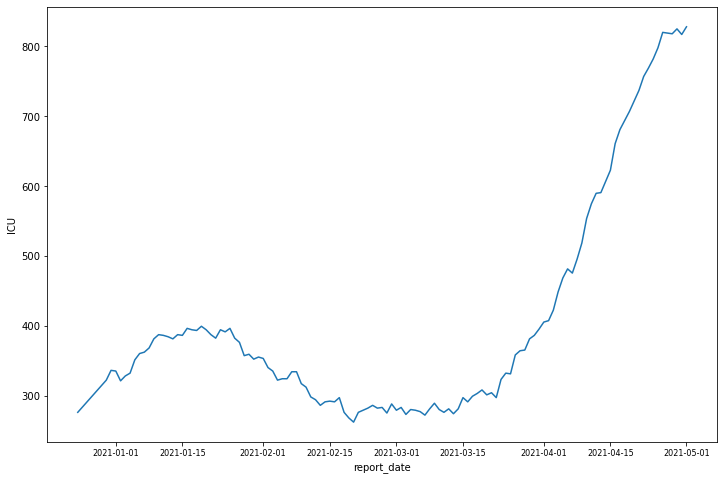

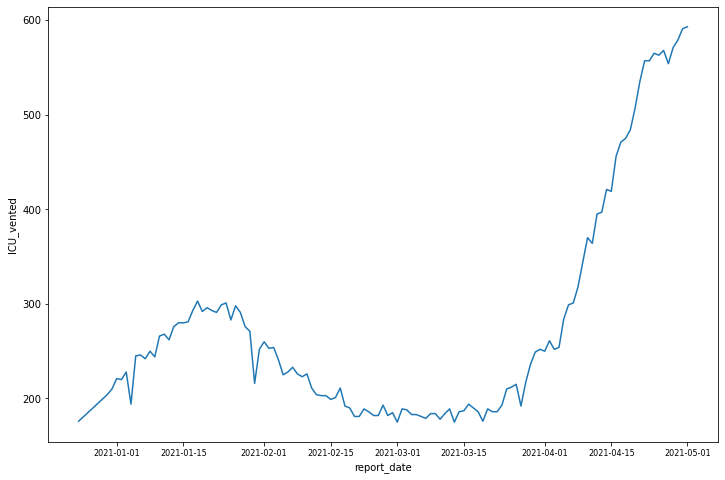

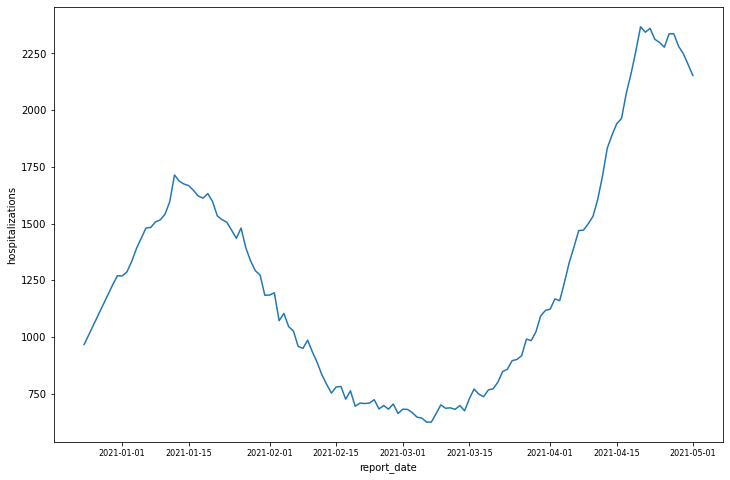

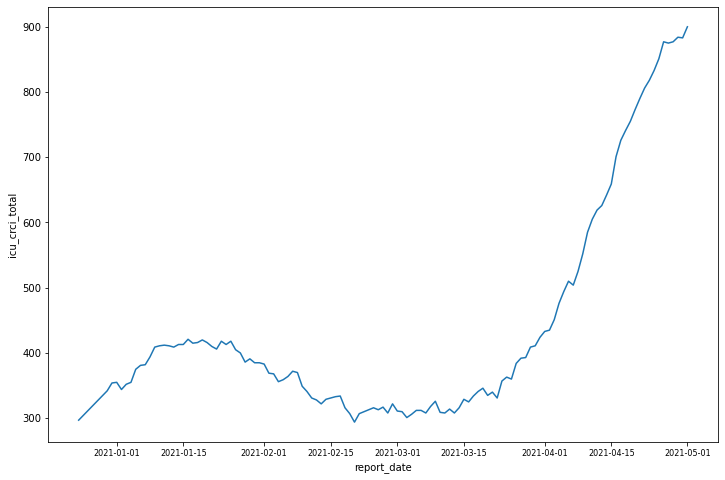

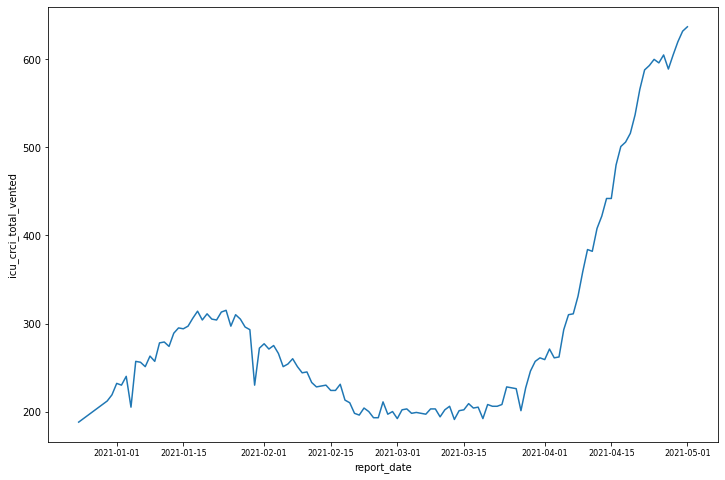

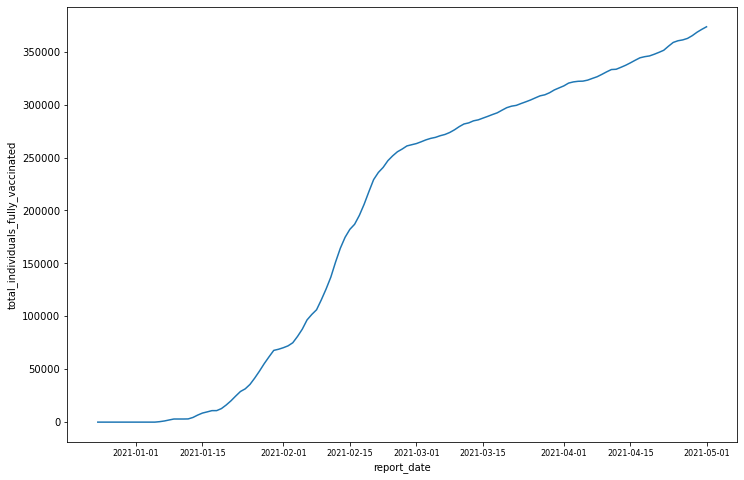

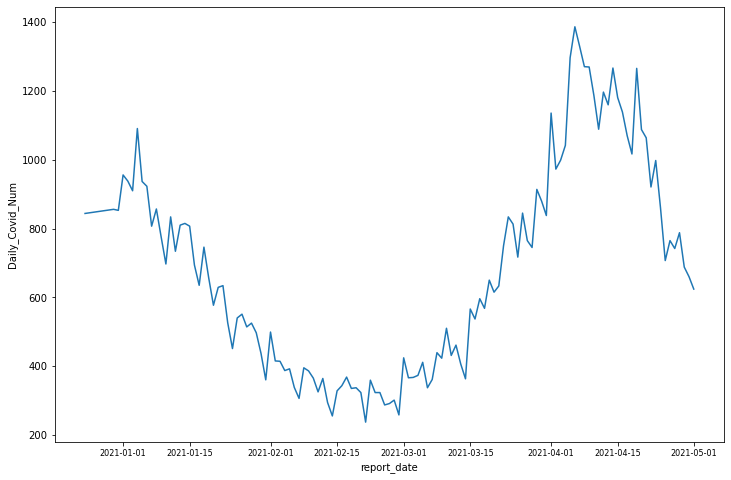

In [10]:
for i in range(1,len(cols)):
    plt.figure(figsize=(12,8))
    sns.lineplot(x='report_date',y=cols[i], data=df)
    plt.xticks(fontsize=8)
    plt.show()



In [117]:
n_days = 4 #Hold out days 

In [118]:
df[cols[1:]][:-4]

,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,277,176,967,297,188,0.0,844
1,323,204,1230,342,212,0.0,856
2,337,210,1270,354,219,0.0,853
3,336,221,1269,355,232,0.0,956
4,322,220,1287,344,230,0.0,938
...,...,...,...,...,...,...,...
115,769,557,2312,818,593,355208.0,998
116,782,565,2298,833,600,358776.0,861
117,798,563,2277,851,596,360354.0,707
118,820,568,2336,877,605,361166.0,765


In [119]:
train_df  = df[cols[1:]][:-4].astype(float)

test_df =  df[cols[1:]][-4:].astype(float)

In [120]:
print(train_df.shape)
print(test_df.shape)

(120, 7)
(4, 7)


In [121]:
scaler = StandardScaler()

scaled_train_df = scaler.fit_transform(train_df)

In [122]:
n_forecast = 7 #days to forecast
n_past = 90 #past days to  learn from 

In [131]:
train_X=[]
train_Y = []


for i in range(n_past,len(train_df)+1 - n_forecast):
    train_X.append(scaled_train_df[i-n_past:i, 0:scaled_train_df.shape[1]])
    train_Y.append(scaled_train_df[i+n_forecast-1:i+n_forecast,0:scaled_train_df.shape[1]])

In [132]:
train_X,train_Y = np.array(train_X), np.array(train_Y)

In [133]:
train_X.shape

(24, 90, 7)

In [134]:
train_Y.shape

(24, 1, 7)

In [54]:
#Building Models : Basic LSTM

In [135]:
model = Sequential()
model.add(LSTM(64,activation='relu', input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16,activation='relu',return_sequences=True))
model.add(LSTM(8,activation='relu',return_sequences=False))
model.add(Dense(train_Y.shape[2]))
model.compile(optimizer='adam',loss='mse')

In [136]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 90, 64)            18432     
_________________________________________________________________
lstm_37 (LSTM)               (None, 90, 32)            12416     
_________________________________________________________________
dropout_10 (Dropout)         (None, 90, 32)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 90, 16)            3136      
_________________________________________________________________
lstm_39 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 63        
Total params: 34,847
Trainable params: 34,847
Non-trainable params: 0
__________________________________________________

In [137]:
early_stop = EarlyStopping(monitor='val_loss',patience=10,mode='min')

In [138]:
history = model.fit(train_X,train_Y,epochs=500,batch_size=8, validation_split=0.15, verbose=1)

Epoch 1/500
3/3 [==============================] - 1s 209ms/step - loss: 2.4319 - val_loss: 5.7570
Epoch 2/500
3/3 [==============================] - 0s 35ms/step - loss: 2.3254 - val_loss: 5.5112
Epoch 3/500
3/3 [==============================] - 0s 37ms/step - loss: 2.1340 - val_loss: 4.9962
Epoch 4/500
3/3 [==============================] - 0s 37ms/step - loss: 2.2732 - val_loss: 4.8337
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 1.9919 - val_loss: 4.7183
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 2.0232 - val_loss: 4.5099
Epoch 7/500
3/3 [==============================] - 0s 36ms/step - loss: 2.0144 - val_loss: 5.3231
Epoch 8/500
3/3 [==============================] - 0s 37ms/step - loss: 1.9857 - val_loss: 4.7966
Epoch 9/500
3/3 [==============================] - 0s 36ms/step - loss: 1.9303 - val_loss: 4.3923
Epoch 10/500
3/3 [==============================] - 0s 36ms/step - loss: 1.8570 - val_loss: 4.3667
Epoch 11/500
3/3 [

Epoch 84/500
3/3 [==============================] - 0s 39ms/step - loss: 0.5161 - val_loss: 1.2513
Epoch 85/500
3/3 [==============================] - 0s 38ms/step - loss: 0.5291 - val_loss: 1.0810
Epoch 86/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5412 - val_loss: 1.0262
Epoch 87/500
3/3 [==============================] - 0s 41ms/step - loss: 0.5313 - val_loss: 1.2460
Epoch 88/500
3/3 [==============================] - 0s 47ms/step - loss: 0.5111 - val_loss: 1.5002
Epoch 89/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5102 - val_loss: 1.5019
Epoch 90/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5251 - val_loss: 1.3448
Epoch 91/500
3/3 [==============================] - 0s 49ms/step - loss: 0.5082 - val_loss: 1.2898
Epoch 92/500
3/3 [==============================] - 0s 42ms/step - loss: 0.5095 - val_loss: 1.3119
Epoch 93/500
3/3 [==============================] - 0s 38ms/step - loss: 0.5096 - val_loss: 1.4485
Epoch 94/5

3/3 [==============================] - 0s 39ms/step - loss: 0.5033 - val_loss: 1.4201
Epoch 167/500
3/3 [==============================] - 0s 42ms/step - loss: 0.5078 - val_loss: 1.3065
Epoch 168/500
3/3 [==============================] - 0s 43ms/step - loss: 0.5135 - val_loss: 1.2815
Epoch 169/500
3/3 [==============================] - 0s 48ms/step - loss: 0.4863 - val_loss: 1.2682
Epoch 170/500
3/3 [==============================] - 0s 39ms/step - loss: 0.4975 - val_loss: 1.2747
Epoch 171/500
3/3 [==============================] - 0s 39ms/step - loss: 0.5026 - val_loss: 1.2933
Epoch 172/500
3/3 [==============================] - 0s 39ms/step - loss: 0.5151 - val_loss: 1.3425
Epoch 173/500
3/3 [==============================] - 0s 37ms/step - loss: 0.4981 - val_loss: 1.3661
Epoch 174/500
3/3 [==============================] - 0s 38ms/step - loss: 0.4843 - val_loss: 1.2685
Epoch 175/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5182 - val_loss: 1.3466
Epoch 176/500


3/3 [==============================] - 0s 36ms/step - loss: 0.4892 - val_loss: 1.3018
Epoch 249/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5079 - val_loss: 1.2936
Epoch 250/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5040 - val_loss: 1.2894
Epoch 251/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5056 - val_loss: 1.3478
Epoch 252/500
3/3 [==============================] - 0s 44ms/step - loss: 0.5039 - val_loss: 1.3341
Epoch 253/500
3/3 [==============================] - 0s 49ms/step - loss: 0.5112 - val_loss: 1.3163
Epoch 254/500
3/3 [==============================] - 0s 49ms/step - loss: 0.4892 - val_loss: 1.3354
Epoch 255/500
3/3 [==============================] - 0s 51ms/step - loss: 0.5140 - val_loss: 1.4365
Epoch 256/500
3/3 [==============================] - 0s 38ms/step - loss: 0.5037 - val_loss: 1.4604
Epoch 257/500
3/3 [==============================] - 0s 39ms/step - loss: 0.5004 - val_loss: 1.4188
Epoch 258/500


3/3 [==============================] - 0s 39ms/step - loss: 0.4980 - val_loss: 1.4987
Epoch 331/500
3/3 [==============================] - 0s 39ms/step - loss: 0.4968 - val_loss: 1.5711
Epoch 332/500
3/3 [==============================] - 0s 40ms/step - loss: 0.5016 - val_loss: 1.6140
Epoch 333/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5245 - val_loss: 1.6128
Epoch 334/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5009 - val_loss: 1.5064
Epoch 335/500
3/3 [==============================] - 0s 36ms/step - loss: 0.4993 - val_loss: 1.4480
Epoch 336/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5018 - val_loss: 1.3491
Epoch 337/500
3/3 [==============================] - 0s 37ms/step - loss: 0.4879 - val_loss: 1.3055
Epoch 338/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5118 - val_loss: 1.3801
Epoch 339/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5022 - val_loss: 1.4448
Epoch 340/500


3/3 [==============================] - 0s 48ms/step - loss: 0.5034 - val_loss: 1.4075
Epoch 413/500
3/3 [==============================] - 0s 38ms/step - loss: 0.5090 - val_loss: 1.3451
Epoch 414/500
3/3 [==============================] - 0s 36ms/step - loss: 0.4997 - val_loss: 1.3142
Epoch 415/500
3/3 [==============================] - 0s 48ms/step - loss: 0.4970 - val_loss: 1.3245
Epoch 416/500
3/3 [==============================] - 0s 46ms/step - loss: 0.5044 - val_loss: 1.3180
Epoch 417/500
3/3 [==============================] - 0s 51ms/step - loss: 0.5060 - val_loss: 1.3796
Epoch 418/500
3/3 [==============================] - 0s 44ms/step - loss: 0.5007 - val_loss: 1.4311
Epoch 419/500
3/3 [==============================] - 0s 47ms/step - loss: 0.5040 - val_loss: 1.4679
Epoch 420/500
3/3 [==============================] - 0s 38ms/step - loss: 0.4997 - val_loss: 1.4950
Epoch 421/500
3/3 [==============================] - 0s 37ms/step - loss: 0.4664 - val_loss: 1.4556
Epoch 422/500


Epoch 494/500
3/3 [==============================] - 0s 45ms/step - loss: 0.5129 - val_loss: 1.1963
Epoch 495/500
3/3 [==============================] - 0s 48ms/step - loss: 0.5075 - val_loss: 1.2565
Epoch 496/500
3/3 [==============================] - 0s 44ms/step - loss: 0.4988 - val_loss: 1.3079
Epoch 497/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5029 - val_loss: 1.3068
Epoch 498/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5045 - val_loss: 1.3275
Epoch 499/500
3/3 [==============================] - 0s 38ms/step - loss: 0.4961 - val_loss: 1.4061
Epoch 500/500
3/3 [==============================] - 0s 39ms/step - loss: 0.5048 - val_loss: 1.4722


<AxesSubplot:>

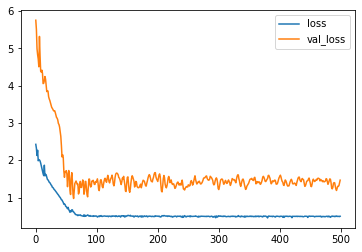

In [140]:
losses= pd.DataFrame(history.history)
losses.plot()

In [141]:
forecast = model.predict(train_X[-n_forecast:])

In [142]:
forecast

array([[1.5958228, 1.4815233, 1.2644678, 1.4809226, 1.4177958, 1.1042033,
        1.5097177],
       [1.611627 , 1.4891733, 1.2726206, 1.487462 , 1.4262469, 1.1131166,
        1.5081723],
       [1.6250737, 1.4992892, 1.2813947, 1.4929335, 1.4342278, 1.1242293,
        1.5076377],
       [1.6362772, 1.5115579, 1.2907029, 1.4973972, 1.4417294, 1.1372939,
        1.5079708],
       [1.6457142, 1.5253683, 1.3002894, 1.5007024, 1.4488778, 1.1517962,
        1.5086255],
       [1.6526049, 1.5406849, 1.3099738, 1.5019077, 1.4547511, 1.1685153,
        1.5080585],
       [1.6585681, 1.5566978, 1.319661 , 1.5017779, 1.4602001, 1.1864738,
        1.5063941]], dtype=float32)

In [66]:
forecast_dates = pd.date_range(list(df['report_date'])[-8], periods =8, freq='1d').tolist()

In [116]:
forecast

array([[1.4841695],
       [1.4986995],
       [1.5080153],
       [1.5156686],
       [1.5277419],
       [1.5350262],
       [1.5487442]], dtype=float32)

In [143]:
def forecaster(forecast):
    forecast_cop =forecast
    #np.repeat(forecast,train_df.shape[1],axis=-1)
    forecast_dates = pd.date_range(list(df['report_date'])[-8], periods =n_forecast, freq='1d').tolist()
    
    y_pred_future = scaler.inverse_transform(forecast_cop)
    
    dates=[]
    for time_ in forecast_dates:
        dates.append(time_.date())
    
    df_forecast = pd.concat([pd.DataFrame({'dates':dates}),pd.DataFrame(y_pred_future)],axis=1)
    
    return df_forecast
    
    

In [144]:
df_forecast = forecaster(forecast)

In [145]:
df_forecast.columns = df.columns

In [146]:
df_forecast['report_date']= pd.to_datetime(df_forecast['report_date'])

In [147]:
df_forecast

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,617.286560,417.646606,1849.029785,639.631775,434.406982,340831.46875,1137.528076
1,2021-04-25,619.509521,418.428741,1853.048584,640.584290,435.306732,342004.06250,1137.057495
2,2021-04-26,621.400879,419.463013,1857.373657,641.381226,436.156433,343466.03125,1136.894653
3,2021-04-27,622.976746,420.717377,1861.961914,642.031433,436.955109,345184.78125,1136.996094
4,2021-04-28,624.304077,422.129364,1866.687378,642.512817,437.716187,347092.65625,1137.195435
5,2021-04-29,625.273315,423.695312,1871.461182,642.688416,438.341492,349292.18750,1137.022827
6,2021-04-30,626.112061,425.332489,1876.236328,642.669495,438.921631,351654.78125,1136.515869


In [73]:
df.tail(8)

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
116,2021-04-24,782,565,2298,833,600,358776.0,861
117,2021-04-25,798,563,2277,851,596,360354.0,707
118,2021-04-26,820,568,2336,877,605,361166.0,765
119,2021-04-27,819,554,2336,875,589,362563.0,742
120,2021-04-28,818,571,2281,877,605,365166.0,788
121,2021-04-29,825,579,2248,884,620,368403.0,688
122,2021-04-30,817,591,2201,883,632,371110.0,660
123,2021-05-01,828,593,2152,900,637,373559.0,624


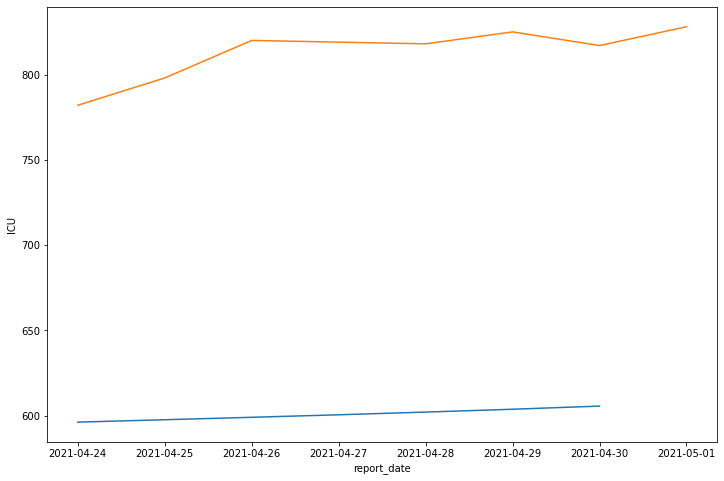

In [74]:
plt.figure(figsize=(12,8))
sns.lineplot(x='report_date',y='ICU',data=df_forecast )
sns.lineplot(x='report_date',y='ICU',data=df.tail(8) )
plt.show()

In [75]:
def accuracy_score(forecast,actual):
    rmse = np.sqrt(np.mean((forecast - actual)**2))
    mape = 100 * np.mean(np.abs(forecast - actual)/np.abs(actual))
    merr = np.mean(np.abs(forecast - actual))
    
    return ({'mean_absolute_pcnt_error':f'{np.round(mape,2)} %', 'root_mean_squared_error' : rmse, 'mean_absolute_error':merr})

In [77]:
df_forecast.shape

(7, 8)

In [78]:
df.shape

(124, 8)

In [79]:

for i in range(1,len(df_forecast.columns)):
    print('\n')
    print(f'printing the accuracy score of {df_forecast.columns[i]}')
    score= accuracy_score(df.tail(n_forecast).iloc[1:,i],df_forecast.iloc[1:,i].values)
    print('----------------------------------------------')
    print(score)
    



printing the accuracy score of ICU
----------------------------------------------
{'mean_absolute_pcnt_error': '36.53 %', 'root_mean_squared_error': 219.7191991973982, 'mean_absolute_error': 219.69209798177084}


printing the accuracy score of ICU_vented
----------------------------------------------
{'mean_absolute_pcnt_error': '37.84 %', 'root_mean_squared_error': 158.60009237232416, 'mean_absolute_error': 158.1608632405599}


printing the accuracy score of hospitalizations
----------------------------------------------
{'mean_absolute_pcnt_error': '15.45 %', 'root_mean_squared_error': 311.67565154643324, 'mean_absolute_error': 302.0484619140625}


printing the accuracy score of icu_crci_total
----------------------------------------------
{'mean_absolute_pcnt_error': '37.92 %', 'root_mean_squared_error': 242.75070636035716, 'mean_absolute_error': 242.67312622070312}


printing the accuracy score of icu_crci_total_vented
----------------------------------------------
{'mean_absolut

In [93]:
model = Sequential()
model.add(Conv1D(64,activation='relu',kernel_size=(3),input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(MaxPooling1D(pool_size=3,padding='same'))
#model.add(Dropout(0.25))
model.add(Conv1D(32,activation='relu',kernel_size=(3)))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(Conv1D(32,activation='relu',kernel_size=(3)))
model.add(MaxPooling1D(pool_size=3,padding='same'))
#model.add(Dropout(0.25))
model.add(LSTM(64,activation='relu',return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(LSTM(16,activation='relu',return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(8,activation='relu',return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[1]))
model.compile(optimizer='adam',loss='mse')

In [94]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 88, 64)            1408      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 28, 32)            6176      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 8, 32)             3104      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 3, 64)            

In [95]:
history = model.fit(train_X,train_Y,epochs=500,batch_size=8, validation_split=0.15, verbose=1)

Epoch 1/500
3/3 [==============================] - 0s 151ms/step - loss: 2.4657 - val_loss: 5.8537
Epoch 2/500
3/3 [==============================] - 0s 7ms/step - loss: 2.4454 - val_loss: 5.8198
Epoch 3/500
3/3 [==============================] - 0s 7ms/step - loss: 2.4241 - val_loss: 5.7759
Epoch 4/500
3/3 [==============================] - 0s 8ms/step - loss: 2.3947 - val_loss: 5.7131
Epoch 5/500
3/3 [==============================] - 0s 8ms/step - loss: 2.3539 - val_loss: 5.6033
Epoch 6/500
3/3 [==============================] - 0s 7ms/step - loss: 2.2781 - val_loss: 5.3462
Epoch 7/500
3/3 [==============================] - 0s 8ms/step - loss: 2.0699 - val_loss: 4.4650
Epoch 8/500
3/3 [==============================] - 0s 7ms/step - loss: 1.4734 - val_loss: 1.0819
Epoch 9/500
3/3 [==============================] - 0s 7ms/step - loss: 0.9781 - val_loss: 1.1011
Epoch 10/500
3/3 [==============================] - 0s 8ms/step - loss: 0.6171 - val_loss: 2.1713
Epoch 11/500
3/3 [=========

Epoch 167/500
3/3 [==============================] - 0s 9ms/step - loss: 0.5314 - val_loss: 1.4354
Epoch 168/500
3/3 [==============================] - 0s 8ms/step - loss: 0.5237 - val_loss: 1.4402
Epoch 169/500
3/3 [==============================] - 0s 9ms/step - loss: 0.5095 - val_loss: 1.5436
Epoch 170/500
3/3 [==============================] - 0s 9ms/step - loss: 0.5290 - val_loss: 1.5677
Epoch 171/500
3/3 [==============================] - 0s 9ms/step - loss: 0.5284 - val_loss: 1.5089
Epoch 172/500
3/3 [==============================] - 0s 8ms/step - loss: 0.5253 - val_loss: 1.5026
Epoch 173/500
3/3 [==============================] - 0s 9ms/step - loss: 0.5311 - val_loss: 1.5197
Epoch 174/500
3/3 [==============================] - 0s 10ms/step - loss: 0.5347 - val_loss: 1.5239
Epoch 175/500
3/3 [==============================] - 0s 9ms/step - loss: 0.5233 - val_loss: 1.4794
Epoch 176/500
3/3 [==============================] - 0s 9ms/step - loss: 0.5288 - val_loss: 1.4574
Epoch 177

Epoch 332/500
3/3 [==============================] - 0s 6ms/step - loss: 0.5274 - val_loss: 1.4177
Epoch 333/500
3/3 [==============================] - 0s 7ms/step - loss: 0.5296 - val_loss: 1.4292
Epoch 334/500
3/3 [==============================] - 0s 7ms/step - loss: 0.5297 - val_loss: 1.4547
Epoch 335/500
3/3 [==============================] - 0s 8ms/step - loss: 0.5103 - val_loss: 1.4809
Epoch 336/500
3/3 [==============================] - 0s 8ms/step - loss: 0.5309 - val_loss: 1.5442
Epoch 337/500
3/3 [==============================] - 0s 8ms/step - loss: 0.5302 - val_loss: 1.5364
Epoch 338/500
3/3 [==============================] - 0s 10ms/step - loss: 0.5285 - val_loss: 1.5213
Epoch 339/500
3/3 [==============================] - 0s 8ms/step - loss: 0.5309 - val_loss: 1.4859
Epoch 340/500
3/3 [==============================] - 0s 7ms/step - loss: 0.5283 - val_loss: 1.4775
Epoch 341/500
3/3 [==============================] - 0s 7ms/step - loss: 0.5195 - val_loss: 1.4491
Epoch 342

Epoch 497/500
3/3 [==============================] - 0s 8ms/step - loss: 0.5046 - val_loss: 1.3794
Epoch 498/500
3/3 [==============================] - 0s 10ms/step - loss: 0.5353 - val_loss: 1.4263
Epoch 499/500
3/3 [==============================] - 0s 10ms/step - loss: 0.5183 - val_loss: 1.4729
Epoch 500/500
3/3 [==============================] - 0s 8ms/step - loss: 0.5298 - val_loss: 1.4916


In [96]:
losses= pd.DataFrame(history.history)

<AxesSubplot:>

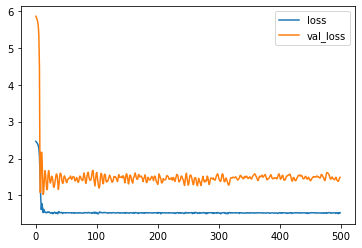

In [97]:
losses.plot()

In [98]:
forecast = model.predict(train_X[-n_forecast:])

In [99]:
df_forecast = forecaster(forecast)

In [100]:
df_forecast.columns = df.columns

In [101]:
df_forecast['report_date']= pd.to_datetime(df_forecast['report_date'])

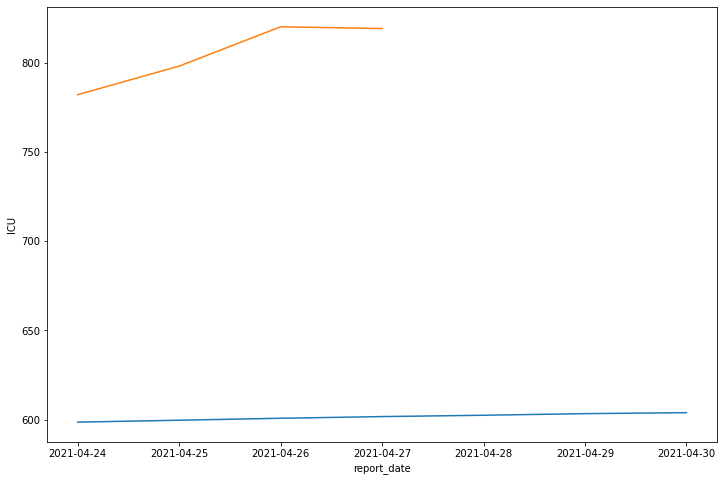

In [102]:
plt.figure(figsize=(12,8))
sns.lineplot(x='report_date',y='ICU',data=df_forecast )
sns.lineplot(x='report_date',y='ICU',data=df[-8:-4] )
plt.show()

In [103]:
df_forecast

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,598.677917,415.806305,1947.150635,637.097473,439.275452,388102.75000,1123.459351
1,2021-04-25,599.738525,416.577240,1950.867676,638.195801,440.078278,389094.78125,1125.755859
2,2021-04-26,600.843689,417.380554,1954.740601,639.340210,440.914795,390128.43750,1128.148804
3,2021-04-27,601.779724,418.060974,1958.021118,640.309570,441.623352,391003.96875,1130.175659
4,2021-04-28,602.524597,418.602386,1960.631348,641.080933,442.187134,391700.62500,1131.788452
5,2021-04-29,603.426025,419.257629,1963.790527,642.014404,442.869476,392543.75000,1133.740234
6,2021-04-30,603.973083,419.655243,1965.707642,642.580872,443.283539,393055.40625,1134.924683


In [105]:
df.tail(n_forecast)

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
117,2021-04-25,798,563,2277,851,596,360354.0,707
118,2021-04-26,820,568,2336,877,605,361166.0,765
119,2021-04-27,819,554,2336,875,589,362563.0,742
120,2021-04-28,818,571,2281,877,605,365166.0,788
121,2021-04-29,825,579,2248,884,620,368403.0,688
122,2021-04-30,817,591,2201,883,632,371110.0,660
123,2021-05-01,828,593,2152,900,637,373559.0,624


## Comments

LSTM not better than hybrid 

Dropouts did not make it better

In all of them, Covid numbers predicted are higher 



In [106]:
model = Sequential()
model.add(Conv1D(64,activation='relu',kernel_size=(3),input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(Conv1D(32,activation='relu',kernel_size=(3)))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(LSTM(64,activation='relu',return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(LSTM(16,activation='relu',return_sequences=True))
model.add(LSTM(8,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[1]))
model.compile(optimizer='adam',loss='mse')

In [107]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 88, 64)            1408      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 28, 32)            6176      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 10, 32)            0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 10, 64)            24832     
_________________________________________________________________
lstm_33 (LSTM)               (None, 10, 32)            12416     
_________________________________________________________________
lstm_34 (LSTM)               (None, 10, 16)           

In [108]:
history = model.fit(train_X,train_Y,epochs=500,batch_size=8, validation_split=0.1, verbose=1)

Epoch 1/500
3/3 [==============================] - 0s 144ms/step - loss: 2.6180 - val_loss: 5.8949
Epoch 2/500
3/3 [==============================] - 0s 10ms/step - loss: 2.5543 - val_loss: 5.7467
Epoch 3/500
3/3 [==============================] - 0s 10ms/step - loss: 2.4738 - val_loss: 5.5186
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 2.2755 - val_loss: 5.0519
Epoch 5/500
3/3 [==============================] - 0s 9ms/step - loss: 1.9301 - val_loss: 3.7471
Epoch 6/500
3/3 [==============================] - 0s 9ms/step - loss: 1.3440 - val_loss: 1.4482
Epoch 7/500
3/3 [==============================] - 0s 9ms/step - loss: 1.4603 - val_loss: 1.9304
Epoch 8/500
3/3 [==============================] - 0s 9ms/step - loss: 1.1579 - val_loss: 2.8844
Epoch 9/500
3/3 [==============================] - 0s 9ms/step - loss: 1.3519 - val_loss: 2.8989
Epoch 10/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9432 - val_loss: 2.4272
Epoch 11/500
3/3 [=======

3/3 [==============================] - 0s 11ms/step - loss: 0.6769 - val_loss: 1.8933
Epoch 85/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8601 - val_loss: 1.8142
Epoch 86/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6551 - val_loss: 1.6151
Epoch 87/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7219 - val_loss: 1.4480
Epoch 88/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7164 - val_loss: 1.3824
Epoch 89/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7835 - val_loss: 1.4264
Epoch 90/500
3/3 [==============================] - 0s 10ms/step - loss: 0.7369 - val_loss: 1.5341
Epoch 91/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6746 - val_loss: 1.6898
Epoch 92/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6396 - val_loss: 1.7164
Epoch 93/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6928 - val_loss: 1.6256
Epoch 94/500
3/3 [=====

3/3 [==============================] - 0s 12ms/step - loss: 0.6863 - val_loss: 1.7303
Epoch 167/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7484 - val_loss: 1.6042
Epoch 168/500
3/3 [==============================] - 0s 12ms/step - loss: 0.5840 - val_loss: 1.5134
Epoch 169/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6264 - val_loss: 1.5417
Epoch 170/500
3/3 [==============================] - 0s 11ms/step - loss: 0.7122 - val_loss: 1.5765
Epoch 171/500
3/3 [==============================] - 0s 13ms/step - loss: 0.7146 - val_loss: 1.5301
Epoch 172/500
3/3 [==============================] - 0s 11ms/step - loss: 0.6984 - val_loss: 1.5883
Epoch 173/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6658 - val_loss: 1.6521
Epoch 174/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6653 - val_loss: 1.7194
Epoch 175/500
3/3 [==============================] - 0s 12ms/step - loss: 0.7794 - val_loss: 1.5892
Epoch 176/500


3/3 [==============================] - 0s 11ms/step - loss: 0.6747 - val_loss: 1.6113
Epoch 331/500
3/3 [==============================] - 0s 9ms/step - loss: 0.6741 - val_loss: 1.6103
Epoch 332/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6366 - val_loss: 1.6123
Epoch 333/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6753 - val_loss: 1.6195
Epoch 334/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6548 - val_loss: 1.6499
Epoch 335/500
3/3 [==============================] - 0s 12ms/step - loss: 0.6372 - val_loss: 1.6565
Epoch 336/500
3/3 [==============================] - 0s 11ms/step - loss: 0.6041 - val_loss: 1.7225
Epoch 337/500
3/3 [==============================] - 0s 13ms/step - loss: 0.6397 - val_loss: 1.6839
Epoch 338/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6754 - val_loss: 1.6261
Epoch 339/500
3/3 [==============================] - 0s 9ms/step - loss: 0.6304 - val_loss: 1.5895
Epoch 340/500
3/

3/3 [==============================] - 0s 11ms/step - loss: 0.6782 - val_loss: 1.6500
Epoch 495/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6128 - val_loss: 1.6186
Epoch 496/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6494 - val_loss: 1.5805
Epoch 497/500
3/3 [==============================] - 0s 9ms/step - loss: 0.6661 - val_loss: 1.5954
Epoch 498/500
3/3 [==============================] - 0s 9ms/step - loss: 0.6194 - val_loss: 1.5991
Epoch 499/500
3/3 [==============================] - 0s 9ms/step - loss: 0.6306 - val_loss: 1.6215
Epoch 500/500
3/3 [==============================] - 0s 9ms/step - loss: 0.6025 - val_loss: 1.5037


<AxesSubplot:>

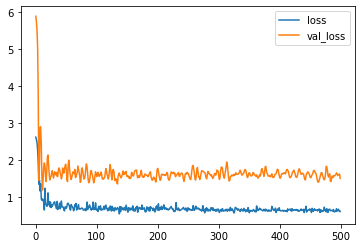

In [109]:
losses= pd.DataFrame(history.history)
losses.plot()


In [110]:
forecast = model.predict(train_X[-n_forecast:])
df_forecast = forecaster(forecast)
df_forecast.columns = df.columns
df_forecast['report_date']= pd.to_datetime(df_forecast['report_date'])

In [111]:
df_forecast

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,601.581909,417.917175,1957.327759,640.104736,441.473602,390818.90625,1129.747192
1,2021-04-25,603.625671,419.402710,1964.490112,642.221130,443.020569,392730.46875,1134.172485
2,2021-04-26,604.935974,420.355164,1969.082153,643.578003,444.012390,393956.00000,1137.009644
3,2021-04-27,606.012451,421.137634,1972.854736,644.692810,444.827209,394962.87500,1139.340454
4,2021-04-28,607.710632,422.372040,1978.806030,646.451355,446.112610,396551.18750,1143.017456
5,2021-04-29,608.735168,423.116760,1982.396606,647.512329,446.888153,397509.50000,1145.235962
6,2021-04-30,610.664734,424.519318,1989.158691,649.510498,448.348663,399314.21875,1149.413940


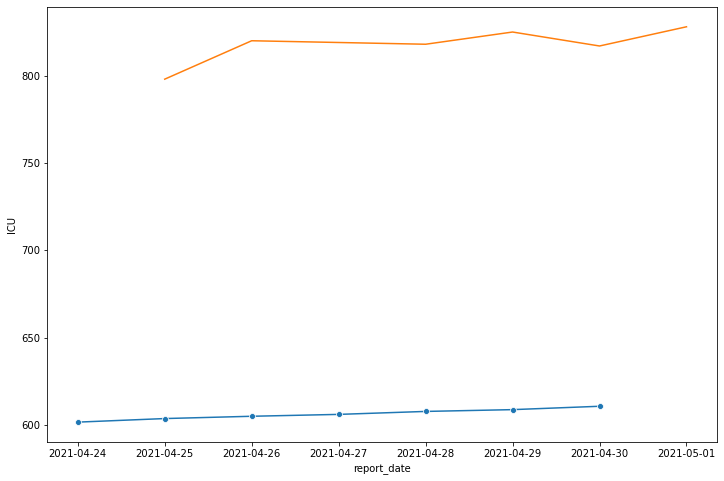

In [113]:
plt.figure(figsize=(12,8))
sns.lineplot(x='report_date',y='ICU',data=df_forecast,marker='o')
sns.lineplot(x='report_date',y='ICU',data=df[-n_forecast:] )
plt.show()

In [115]:
for i in range(1,len(df_forecast.columns)):
    print('\n')
    print(f'printing the accuracy score of {df_forecast.columns[i]}')
    score= accuracy_score(df.tail(n_forecast).iloc[1:,i],df_forecast.iloc[1:,i].values)
    print('----------------------------------------------')
    print(score)
    



printing the accuracy score of ICU
----------------------------------------------
{'mean_absolute_pcnt_error': '35.3 %', 'root_mean_squared_error': 214.2442163262845, 'mean_absolute_error': 214.21922810872397}


printing the accuracy score of ICU_vented
----------------------------------------------
{'mean_absolute_pcnt_error': '36.54 %', 'root_mean_squared_error': 154.6521182141571, 'mean_absolute_error': 154.18272908528647}


printing the accuracy score of hospitalizations
----------------------------------------------
{'mean_absolute_pcnt_error': '14.33 %', 'root_mean_squared_error': 292.7945625594129, 'mean_absolute_error': 282.8686116536458}


printing the accuracy score of icu_crci_total
----------------------------------------------
{'mean_absolute_pcnt_error': '36.71 %', 'root_mean_squared_error': 237.0909394217129, 'mean_absolute_error': 237.00564575195312}


printing the accuracy score of icu_crci_total_vented
----------------------------------------------
{'mean_absolute_p

In [72]:
pd.DataFrame(index=df_forecast.columns[1:],accuracy_score(df.tail(8).iloc[1:,i],df_forecast.iloc[1:,i].values))
for i in range(1,len(df_forecast.columns)):
    print('\n')
    print(f'printing the accuracy score of {df_forecast.columns[i]}')
    score= accuracy_score(df.tail(8).iloc[1:,i],df_forecast.iloc[1:,i].values)
    print('----------------------------------------------')
    print(score)

SyntaxError: positional argument follows keyword argument (<ipython-input-72-d679188416f8>, line 1)

In [77]:
model = Sequential()
model.add(Conv1D(64,activation='relu',kernel_size=(3),input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(LSTM(64,activation='relu',return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(LSTM(16,activation='relu',return_sequences=True))
model.add(LSTM(8,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[1]))
model.compile(optimizer='adam',loss='mse')

In [78]:
history = model.fit(train_X,train_Y,epochs=500,batch_size=8, validation_split=0.1, verbose=1)

Epoch 1/500
3/3 [==============================] - 1s 175ms/step - loss: 0.4596 - val_loss: 0.9595
Epoch 2/500
3/3 [==============================] - 0s 24ms/step - loss: 0.4441 - val_loss: 0.9449
Epoch 3/500
3/3 [==============================] - 0s 24ms/step - loss: 0.4323 - val_loss: 0.9273
Epoch 4/500
3/3 [==============================] - 0s 31ms/step - loss: 0.4215 - val_loss: 0.9049
Epoch 5/500
3/3 [==============================] - 0s 44ms/step - loss: 0.4060 - val_loss: 0.8713
Epoch 6/500
3/3 [==============================] - 0s 37ms/step - loss: 0.3829 - val_loss: 0.8178
Epoch 7/500
3/3 [==============================] - 0s 34ms/step - loss: 0.3661 - val_loss: 0.6960
Epoch 8/500
3/3 [==============================] - 0s 37ms/step - loss: 0.2646 - val_loss: 0.2596
Epoch 9/500
3/3 [==============================] - 0s 31ms/step - loss: 0.1039 - val_loss: 0.0035
Epoch 10/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0985 - val_loss: 0.2334
Epoch 11/500
3/3 [

3/3 [==============================] - 0s 24ms/step - loss: 0.0481 - val_loss: 0.0032
Epoch 165/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0513 - val_loss: 3.3744e-04
Epoch 166/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0335 - val_loss: 0.0022
Epoch 167/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0248 - val_loss: 8.5400e-04
Epoch 168/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0335 - val_loss: 0.0199
Epoch 169/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0169 - val_loss: 0.0342
Epoch 170/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0531 - val_loss: 0.0266
Epoch 171/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0522 - val_loss: 0.0199
Epoch 172/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0594 - val_loss: 0.0138
Epoch 173/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0455 - val_loss: 0.0084
Epoch 

Epoch 246/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0393 - val_loss: 0.0076
Epoch 247/500
3/3 [==============================] - 0s 45ms/step - loss: 0.0260 - val_loss: 0.0059
Epoch 248/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0303 - val_loss: 0.0066
Epoch 249/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0223 - val_loss: 0.0088
Epoch 250/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0079 - val_loss: 0.0095
Epoch 251/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 252/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0089 - val_loss: 0.0106
Epoch 253/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0090 - val_loss: 0.0134
Epoch 254/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0089 - val_loss: 0.0177
Epoch 255/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0161 - val_loss: 0.0201


Epoch 408/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0159 - val_loss: 7.8153e-04
Epoch 409/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 410/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0068 - val_loss: 1.7879e-04
Epoch 411/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0057 - val_loss: 2.0663e-04
Epoch 412/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0106 - val_loss: 1.8790e-04
Epoch 413/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0081 - val_loss: 6.0957e-04
Epoch 414/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 415/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0092 - val_loss: 0.0027
Epoch 416/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0089 - val_loss: 0.0030
Epoch 417/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0079

Epoch 489/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0128 - val_loss: 0.0025
Epoch 490/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0069 - val_loss: 0.0039
Epoch 491/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0057 - val_loss: 7.9167e-04
Epoch 492/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0100 - val_loss: 4.5591e-04
Epoch 493/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 494/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 495/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 496/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0018 - val_loss: 8.4429e-04
Epoch 497/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0049 - val_loss: 3.7211e-04
Epoch 498/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0071 - v

In [79]:
forecast = model.predict(train_X[-n_forecast:])
df_forecast = forecaster(forecast)
df_forecast.columns = df.columns
df_forecast['report_date']= pd.to_datetime(df_forecast['report_date'])

In [80]:
df_forecast

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,717.041382,495.355957,2045.000244,769.235413,527.919678,295545.06250,1174.428345
1,2021-04-25,732.833862,506.498535,2094.390625,785.765076,539.742737,305824.71875,1207.033936
2,2021-04-26,747.773743,517.039612,2141.114502,801.402344,550.927551,315549.40625,1237.879395
3,2021-04-27,762.449768,527.394592,2187.013672,816.763428,561.914856,325102.37500,1268.179932
4,2021-04-28,775.138916,536.347534,2226.698486,830.044861,571.414551,333361.96875,1294.378418
5,2021-04-29,789.258362,546.309692,2270.856445,844.823364,581.985107,342552.59375,1323.529785
6,2021-04-30,802.706970,555.798645,2312.916504,858.899780,592.053467,351306.59375,1351.296265
7,2021-05-01,815.026367,564.490723,2351.445068,871.794189,601.276428,359325.53125,1376.731323


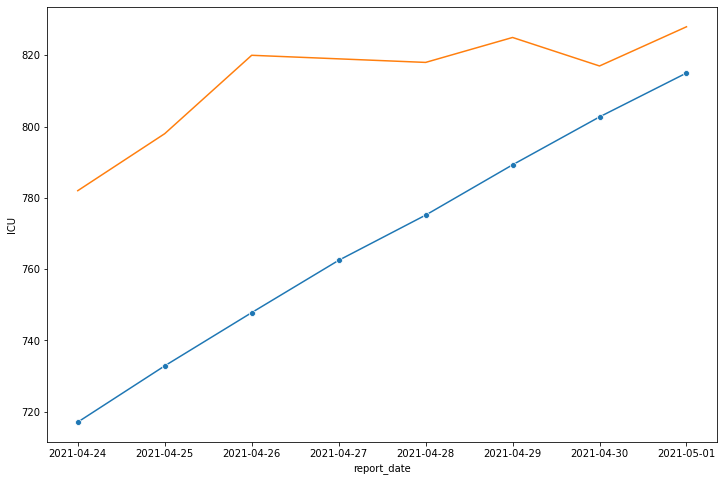

In [81]:
plt.figure(figsize=(12,8))
sns.lineplot(x='report_date',y='ICU',data=df_forecast,marker='o')
sns.lineplot(x='report_date',y='ICU',data=df[-8:] )
plt.show()

In [55]:
model = Sequential()
model.add(Conv1D(64,activation='relu',kernel_size=(3),input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(32,activation='relu',kernel_size=(3)))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(16,activation='relu',kernel_size=(3)))
model.add(MaxPooling1D(pool_size=3,padding='same'))
model.add(LSTM(64,activation='relu',return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(LSTM(16,activation='relu',return_sequences=True))
model.add(LSTM(8,activation='relu',return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[1]))
model.compile(optimizer='adam',loss='mse')

In [56]:
history = model.fit(train_X,train_Y,epochs=1000,batch_size=12, validation_split=0.2, verbose=1)

Epoch 1/1000
2/2 [==============================] - 1s 257ms/step - loss: 2.7684 - val_loss: 8.2840
Epoch 2/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.7505 - val_loss: 8.2654
Epoch 3/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.7294 - val_loss: 8.2459
Epoch 4/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.7044 - val_loss: 8.2257
Epoch 5/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.6715 - val_loss: 8.2048
Epoch 6/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.6355 - val_loss: 8.1827
Epoch 7/1000
2/2 [==============================] - 0s 18ms/step - loss: 2.5851 - val_loss: 8.1591
Epoch 8/1000
2/2 [==============================] - 0s 21ms/step - loss: 2.5219 - val_loss: 8.1345
Epoch 9/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.4426 - val_loss: 8.1099
Epoch 10/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.3299 - val_loss: 8.0852
Epoch 11

2/2 [==============================] - 0s 18ms/step - loss: 4.7764e-04 - val_loss: 5.7255
Epoch 161/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.3021e-04 - val_loss: 5.7211
Epoch 162/1000
2/2 [==============================] - 0s 18ms/step - loss: 3.3741e-04 - val_loss: 5.6633
Epoch 163/1000
2/2 [==============================] - 0s 19ms/step - loss: 5.7838e-04 - val_loss: 5.6613
Epoch 164/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.5990e-04 - val_loss: 5.6685
Epoch 165/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 5.5570
Epoch 166/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 5.5176
Epoch 167/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 5.4671
Epoch 168/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 5.3572
Epoch 169/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0013 - va

2/2 [==============================] - 0s 19ms/step - loss: 3.4265e-04 - val_loss: 1.2308
Epoch 317/1000
2/2 [==============================] - 0s 19ms/step - loss: 1.0195e-04 - val_loss: 1.2453
Epoch 318/1000
2/2 [==============================] - 0s 18ms/step - loss: 2.9029e-04 - val_loss: 1.1702
Epoch 319/1000
2/2 [==============================] - 0s 18ms/step - loss: 4.3882e-04 - val_loss: 1.1942
Epoch 320/1000
2/2 [==============================] - 0s 19ms/step - loss: 4.3980e-04 - val_loss: 1.1488
Epoch 321/1000
2/2 [==============================] - 0s 18ms/step - loss: 5.8561e-04 - val_loss: 1.1809
Epoch 322/1000
2/2 [==============================] - 0s 19ms/step - loss: 3.9352e-04 - val_loss: 1.1665
Epoch 323/1000
2/2 [==============================] - 0s 19ms/step - loss: 8.5884e-05 - val_loss: 1.0846
Epoch 324/1000
2/2 [==============================] - 0s 17ms/step - loss: 6.3148e-04 - val_loss: 1.1299
Epoch 325/1000
2/2 [==============================] - 0s 19ms/step - l

2/2 [==============================] - 0s 18ms/step - loss: 1.4495e-04 - val_loss: 0.4644
Epoch 473/1000
2/2 [==============================] - 0s 19ms/step - loss: 1.8337e-04 - val_loss: 0.4479
Epoch 474/1000
2/2 [==============================] - 0s 18ms/step - loss: 7.3187e-04 - val_loss: 0.4283
Epoch 475/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.7685e-04 - val_loss: 0.4088
Epoch 476/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.4801e-04 - val_loss: 0.4096
Epoch 477/1000
2/2 [==============================] - 0s 18ms/step - loss: 6.1127e-04 - val_loss: 0.4398
Epoch 478/1000
2/2 [==============================] - 0s 18ms/step - loss: 3.8113e-04 - val_loss: 0.5026
Epoch 479/1000
2/2 [==============================] - 0s 18ms/step - loss: 1.8751e-04 - val_loss: 0.5290
Epoch 480/1000
2/2 [==============================] - 0s 19ms/step - loss: 5.0398e-04 - val_loss: 0.5538
Epoch 481/1000
2/2 [==============================] - 0s 18ms/step - l

2/2 [==============================] - 0s 18ms/step - loss: 3.9055e-05 - val_loss: 0.6321
Epoch 629/1000
2/2 [==============================] - 0s 20ms/step - loss: 3.6136e-05 - val_loss: 0.6362
Epoch 630/1000
2/2 [==============================] - 0s 18ms/step - loss: 5.4035e-05 - val_loss: 0.6415
Epoch 631/1000
2/2 [==============================] - 0s 18ms/step - loss: 7.4649e-05 - val_loss: 0.6269
Epoch 632/1000
2/2 [==============================] - 0s 19ms/step - loss: 7.3386e-05 - val_loss: 0.5894
Epoch 633/1000
2/2 [==============================] - 0s 19ms/step - loss: 1.0638e-04 - val_loss: 0.6069
Epoch 634/1000
2/2 [==============================] - 0s 18ms/step - loss: 1.8407e-04 - val_loss: 0.5830
Epoch 635/1000
2/2 [==============================] - 0s 19ms/step - loss: 1.7333e-04 - val_loss: 0.5961
Epoch 636/1000
2/2 [==============================] - 0s 18ms/step - loss: 8.8769e-05 - val_loss: 0.5757
Epoch 637/1000
2/2 [==============================] - 0s 17ms/step - l

2/2 [==============================] - 0s 20ms/step - loss: 8.6450e-05 - val_loss: 0.4549
Epoch 786/1000
2/2 [==============================] - 0s 18ms/step - loss: 1.2354e-04 - val_loss: 0.4733
Epoch 787/1000
2/2 [==============================] - 0s 18ms/step - loss: 3.4445e-04 - val_loss: 0.4361
Epoch 788/1000
2/2 [==============================] - 0s 18ms/step - loss: 5.6829e-04 - val_loss: 0.4308
Epoch 789/1000
2/2 [==============================] - 0s 18ms/step - loss: 1.7538e-04 - val_loss: 0.4352
Epoch 790/1000
2/2 [==============================] - 0s 18ms/step - loss: 3.1725e-04 - val_loss: 0.3968
Epoch 791/1000
2/2 [==============================] - 0s 19ms/step - loss: 6.9857e-04 - val_loss: 0.4611
Epoch 792/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.4153
Epoch 793/1000
2/2 [==============================] - 0s 18ms/step - loss: 9.1940e-04 - val_loss: 0.4262
Epoch 794/1000
2/2 [==============================] - 0s 19ms/step - loss:

2/2 [==============================] - 0s 19ms/step - loss: 5.8129e-05 - val_loss: 0.4387
Epoch 942/1000
2/2 [==============================] - 0s 18ms/step - loss: 6.3930e-05 - val_loss: 0.4459
Epoch 943/1000
2/2 [==============================] - 0s 19ms/step - loss: 5.5839e-05 - val_loss: 0.4383
Epoch 944/1000
2/2 [==============================] - 0s 19ms/step - loss: 3.1010e-05 - val_loss: 0.4420
Epoch 945/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.8825e-05 - val_loss: 0.4398
Epoch 946/1000
2/2 [==============================] - 0s 19ms/step - loss: 3.3234e-05 - val_loss: 0.4361
Epoch 947/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.3283e-05 - val_loss: 0.4440
Epoch 948/1000
2/2 [==============================] - 0s 18ms/step - loss: 3.8709e-05 - val_loss: 0.4440
Epoch 949/1000
2/2 [==============================] - 0s 18ms/step - loss: 1.7119e-05 - val_loss: 0.4484
Epoch 950/1000
2/2 [==============================] - 0s 19ms/step - l

<AxesSubplot:>

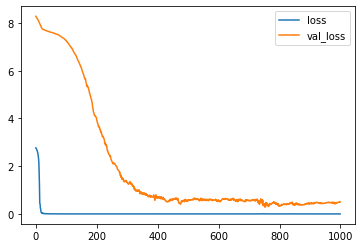

In [57]:
losses= pd.DataFrame(history.history)
losses.plot()

In [58]:
def Model_forecast(model):
    forecast = model.predict(train_X[-n_forecast:])
    df_forecast = forecaster(forecast)
    df_forecast.columns = df.columns
    df_forecast['report_date']= pd.to_datetime(df_forecast['report_date'])
    return df_forecast
    

In [59]:
Model_forecast(model)

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
0,2021-04-24,720.894531,504.643646,2375.462158,763.659729,531.785400,502413.96875,1388.090576
1,2021-04-25,735.951538,515.588379,2428.229980,779.252136,543.182556,516497.06250,1420.692993
2,2021-04-26,756.526001,530.543640,2500.333740,800.558167,558.756104,535740.75000,1465.242188
3,2021-04-27,735.263062,515.087891,2425.817139,778.539185,542.661438,515853.12500,1419.202271
4,2021-04-28,725.778076,508.193420,2392.576660,768.716919,535.481934,506981.65625,1398.664795
5,2021-04-29,709.182556,496.130402,2334.417236,751.531311,522.920166,491459.56250,1362.731079
6,2021-04-30,687.720886,480.530273,2259.204346,729.306580,506.675140,471386.15625,1316.260986
7,2021-05-01,679.214600,474.347137,2229.393555,720.497803,500.236420,463430.03125,1297.842529


In [50]:
df.tail(8)

,report_date,ICU,ICU_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,total_individuals_fully_vaccinated,Daily_Covid_Num
116,2021-04-24,782,565,2298,833,600,358776.0,861
117,2021-04-25,798,563,2277,851,596,360354.0,707
118,2021-04-26,820,568,2336,877,605,361166.0,765
119,2021-04-27,819,554,2336,875,589,362563.0,742
120,2021-04-28,818,571,2281,877,605,365166.0,788
121,2021-04-29,825,579,2248,884,620,368403.0,688
122,2021-04-30,817,591,2201,883,632,371110.0,660
123,2021-05-01,828,593,2152,900,637,373559.0,624
